# AirBnB in Amsterdam

Import packages.

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('Listings.csv')
data.info()
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13849 entries, 0 to 13848
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13849 non-null  int64  
 1   name                            13849 non-null  object 
 2   host_id                         13849 non-null  int64  
 3   host_name                       13813 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   13849 non-null  object 
 6   latitude                        13849 non-null  float64
 7   longitude                       13849 non-null  float64
 8   room_type                       13849 non-null  object 
 9   price                           13849 non-null  int64  
 10  minimum_nights                  13849 non-null  int64  
 11  number_of_reviews               13849 non-null  int64  
 12  last_review                     

id                                               name   host_id  \
0       9784567                             nice Room in Amsterdam  27280608   
1      13163805        Best cost benefit room near a metro station  35491461   
2       3719167  Nice  room in A´dam SE near nature & heart centre  18991270   
3      13188367     Private room 15min metro ride from city center  73797940   
4       4831606    Room in Amsterdam in a new house!! Free Bicycle  24314617   
...         ...                                                ...       ...   
13844  12502581                Cosy complete appartment max 3 pers  41341758   
13845  12651857                 Independent big room 13 min center  32748297   
13846  13450662            Fab home 15minutes from the city centre  48703385   
13847  13722497                  Spacious, split level appt 5 pers  19237729   
13848  13612056                        Family House near Amsterdam  78791769   

      host_name  neighbourhood_group    neighbourhood   latitude  longitude  \
0         Petra                  NaN     Bijlmer-Oost  52.323369   4.977730   
1       Phillip                  NaN     Bijlmer-Oost  52.315635   4.978166   
2         Maria                  NaN     Bijlmer-Oost  52.316711   4.986618   
3         Diana                  NaN     Bijlmer-Oost  52.321204   4.976630   
4         Jorim                  NaN     Bijlmer-Oost  52.327270   4.967352   
...         ...                  ...              ...        ...        ...   
13844  Carolien                  NaN       Noord-West  52.422604   4.908214   
13845    Sophia                  NaN  Bijlmer-Centrum  52.325648   4.936263   
13846    Tillan                  NaN  Watergraafsmeer  52.342093   4.957043   
13847     Marco                  NaN  Watergraafsmeer  52.335153   4.941866   
13848    Allard                  NaN  Watergraafsmeer  52.340245   4.960007   

             room_type  price  minimum_nights  number_of_reviews last_review  \
0         Private room     95               1                  5  2016-06-27   
1         Private room     60               1                  4  2016-06-27   
2         Private room     45               5                 11  2016-01-02   
3         Private room     35               1                  2  2016-05-31   
4         Private room     39              14                 12  2016-03-22   
...                ...    ...             ...                ...         ...   
13844  Entire home/apt     90               2                  3  2016-06-26   
13845     Private room     49               2                  4  2016-06-03   
13846  Entire home/apt    140               2                  0         NaN   
13847  Entire home/apt    175               1                  0         NaN   
13848  Entire home/apt    155               3                  0         NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  
0                   0.81                               3               365  
1                   4.00                               1                77  
2                   0.48                               1                23  
3                   1.62                               1                10  
4                   0.65                               1               338  
...                  ...                             ...               ...  
13844               3.00                               1               321  
13845               1.90                               1                55  
13846                NaN                              71               172  
13847                NaN                               1               276  
13848                NaN                               1                41  

[13849 rows x 16 columns]

## Adjust/expand dataset

Drop the unused column 'neighbourhood_group' and add an estimate of the occupancy and revenue of the listings. According to Airbnb 70% of guests write a review, so we can use this to convert #reviews into #guests. We also have to estimate the number of nights people stay, which we will very roughly estimate as the minimum #nights times 1.44 to get an average of 3.9, as is the true average*.

*(https://www.cbs.nl/-/media/_pdf/2019/51/discussionpaper-on-platform-related-accommodations.pdf)

In [61]:
min_night_avg = (data['minimum_nights']*data['number_of_reviews']).sum()/data.agg(sum)['number_of_reviews']
f = 3.9/min_night_avg
print('Factor needed to convert minumum #nights to avg stay: {}'.format(f))

Factor needed to convert minumum #nights to avg stay: 1.440517943371663


In [62]:
data.drop('neighbourhood_group', axis=1, inplace=True)
# https://capitalcounselor.com/airbnb-statistics/
# Average number of nights per booking estimated to be twice the minimum
# Number of guests per month estimated by assuming review ratio of 70%
data['occupancy'] = data['reviews_per_month']/0.7*data['minimum_nights']*1.44
data['revenue_per_month'] = data['occupancy']*data['price']

We also would like to know the location in terms of distance to the city center, for which we will choose the Oude Kerk.

In [63]:
# Amsterdam center (Oude Kerk) coordinates: 52°22'26.5"N 4°53'53.0"E
co_ctr = [(52 + (22 + 26.5/60)/60)*np.pi/180, (4 + (53 + 53.0/60)/60)*np.pi/180]
R = 6371

# https://www.movable-type.co.uk/scripts/latlong.html
def distance_center(row):
    coor = [row['latitude']*np.pi/180, row['longitude']*np.pi/180]
    dphi = co_ctr[0]-coor[0]
    dlab = co_ctr[1]-coor[1]
    a = np.sin(dphi/2)**2+np.cos(co_ctr[0])*np.cos(coor[0])*np.sin(dlab/2)**2
    c = 2*np.arctan2(np.sqrt(a),  np.sqrt(1-a))
    d = R*c
    return d

data['center distance'] = data.apply(distance_center, axis=1)

In [64]:
print(data.info())
display(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13849 entries, 0 to 13848
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              13849 non-null  int64  
 1   name                            13849 non-null  object 
 2   host_id                         13849 non-null  int64  
 3   host_name                       13813 non-null  object 
 4   neighbourhood                   13849 non-null  object 
 5   latitude                        13849 non-null  float64
 6   longitude                       13849 non-null  float64
 7   room_type                       13849 non-null  object 
 8   price                           13849 non-null  int64  
 9   minimum_nights                  13849 non-null  int64  
 10  number_of_reviews               13849 non-null  int64  
 11  last_review                     11386 non-null  object 
 12  reviews_per_month               

id                                               name   host_id  \
0       9784567                             nice Room in Amsterdam  27280608   
1      13163805        Best cost benefit room near a metro station  35491461   
2       3719167  Nice  room in A´dam SE near nature & heart centre  18991270   
3      13188367     Private room 15min metro ride from city center  73797940   
4       4831606    Room in Amsterdam in a new house!! Free Bicycle  24314617   
...         ...                                                ...       ...   
13844  12502581                Cosy complete appartment max 3 pers  41341758   
13845  12651857                 Independent big room 13 min center  32748297   
13846  13450662            Fab home 15minutes from the city centre  48703385   
13847  13722497                  Spacious, split level appt 5 pers  19237729   
13848  13612056                        Family House near Amsterdam  78791769   

      host_name    neighbourhood   latitude  longitude        room_type  \
0         Petra     Bijlmer-Oost  52.323369   4.977730     Private room   
1       Phillip     Bijlmer-Oost  52.315635   4.978166     Private room   
2         Maria     Bijlmer-Oost  52.316711   4.986618     Private room   
3         Diana     Bijlmer-Oost  52.321204   4.976630     Private room   
4         Jorim     Bijlmer-Oost  52.327270   4.967352     Private room   
...         ...              ...        ...        ...              ...   
13844  Carolien       Noord-West  52.422604   4.908214  Entire home/apt   
13845    Sophia  Bijlmer-Centrum  52.325648   4.936263     Private room   
13846    Tillan  Watergraafsmeer  52.342093   4.957043  Entire home/apt   
13847     Marco  Watergraafsmeer  52.335153   4.941866  Entire home/apt   
13848    Allard  Watergraafsmeer  52.340245   4.960007  Entire home/apt   

       price  minimum_nights  number_of_reviews last_review  \
0         95               1                  5  2016-06-27   
1         60               1                  4  2016-06-27   
2         45               5                 11  2016-01-02   
3         35               1                  2  2016-05-31   
4         39              14                 12  2016-03-22   
...      ...             ...                ...         ...   
13844     90               2                  3  2016-06-26   
13845     49               2                  4  2016-06-03   
13846    140               2                  0         NaN   
13847    175               1                  0         NaN   
13848    155               3                  0         NaN   

       reviews_per_month  calculated_host_listings_count  availability_365  \
0                   0.81                               3               365   
1                   4.00                               1                77   
2                   0.48                               1                23   
3                   1.62                               1                10   
4                   0.65                               1               338   
...                  ...                             ...               ...   
13844               3.00                               1               321   
13845               1.90                               1                55   
13846                NaN                              71               172   
13847                NaN                               1               276   
13848                NaN                               1                41   

       occupancy  revenue_per_month  center distance  
0       1.666286         158.297143         7.811383  
1       8.228571         493.714286         8.471872  
2       4.937143         222.171429         8.764202  
3       3.332571         116.640000         7.936380  
4      18.720000         730.080000         7.013155  
...          ...                ...              ...  
13844  12.342857        1110.857143         5.445255  
13845   7.817143 

# Neighbourhoods

We will take a look at some neighbourhood-specific data and give an advice on where to go as a tourist. We will look at the price, popularity and number of listings

In [65]:
# Price separately for hosing type???
data_per_nbh = data[['neighbourhood', 'price', 'revenue_per_month', 'occupancy', 'center distance']].groupby('neighbourhood')
info_per_nbh = data_per_nbh.mean()
info_per_nbh['#listings'] = data_per_nbh.size()
# Multiply by min nights?
info_per_nbh['popularity'] = info_per_nbh['occupancy']*info_per_nbh['#listings']
display(info_per_nbh)

price  revenue_per_month  \
neighbourhood                                                           
Bijlmer-Centrum                          56.573770         324.861061   
Bijlmer-Oost                             72.652778         549.927849   
Bos en Lommer                            99.666187         546.150302   
Buitenveldert - Zuidas                  118.143750         535.200540   
Centrum-Oost                            160.487370        1521.061136   
Centrum-West                            168.872872        1335.748445   
De Aker - Nieuw Sloten                  119.824176         677.197910   
De Baarsjes - Oud-West                  124.610037         744.997868   
De Pijp - Rivierenbuurt                 131.304803         821.959153   
Gaasperdam - Driemond                    79.253968         414.581822   
Geuzenveld - Slotermeer                  96.891304         589.455086   
IJburg - Zeeburgereiland                141.014706         661.680337   
Noord-Oost                              113.188679        1308.569919   
Noord-West                               99.440860         593.146150   
Oostelijk Havengebied - Indische Buurt  118.763689         609.302021   
Osdorp                                   94.515152         692.378606   
Oud-Noord                               127.667519         730.810489   
Oud-Oost                                120.616625         643.716598   
Slotervaart                              95.603571         652.028586   
Watergraafsmeer                         123.140884         621.434562   
Westerpark                              122.608358        1173.700860   
Zuid                                    151.093069         711.646203   

                                        occupancy  center distance  #listings  \
neighbourhood                                                                   
Bijlmer-Centrum                          6.002449         7.195318         61   
Bijlmer-Oost                             8.425747         7.981341         72   
Bos en Lommer                            5.870142         3.220687        695   
Buitenveldert - Zuidas                   5.289773         5.102886        160   
Centrum-Oost                            10.265956         1.282072       1346   
Centrum-West                             8.747290         0.942392       1880   
De Aker - Nieuw Sloten                   7.214400         7.432965         91   
De Baarsjes - Oud-West                   6.342323         2.570992       2431   
De Pijp - Rivierenbuurt                  6.588234         2.588001       1624   
Gaasperdam - Driemond                    6.360841         9.955006         63   
Geuzenveld - Slotermeer                  7.335380         5.237871        138   
IJburg - Zeeburgereiland                 5.726951         6.665600        272   
Noord-Oost                              11.526598         4.877426        159   
Noord-West                               6.873158         4.261171        186   
Oostelijk Havengebied - Indische Buurt   5.413182         2.933732        694   
Osdorp                                   7.661897         6.907508         99   
Oud-Noord                                6.455707         2.402473        391   
Oud-Oost                                 5.696498         2.395317        806   
Slotervaart                              7.255067         4.434428        280   
Watergraafsmeer                          5.720616         3.724942        362   
Westerpark                              10.892943         1.943451       1029   
Zuid                                     5.738771         3.492319       1010   

                                          popularity  
neighbourhood                                         
Bijlmer-Centrum                           366.149388  
Bijlmer-Oost                              606.653757  
Bos en Lommer                            4079.748783  
Buitenveldert - Zuidas                    846.363645  
Centrum-Oost     

In [66]:
# y = info_per_nbh.sort_values('center distance', ascending=True)

# x = np.arange(len(y))  # the label locations
# width = 0.35  # the width of the bars

# fig, ax = plt.subplots()
# rects1 = ax.bar(x - width/2, y['center distance'], width, label='Men')
# rects2 = ax.bar(x + width/2, y['price'], width, label='Women')

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Scores')
# ax.set_title('Scores by group and gender')
# ax.set_xticks(x)
# ax.set_xticklabels(labels)
# ax.legend()

# fig.tight_layout()
# plt.show()

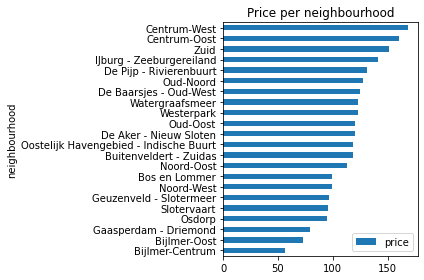

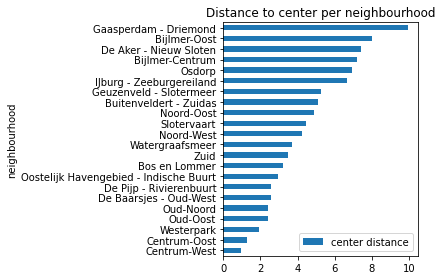

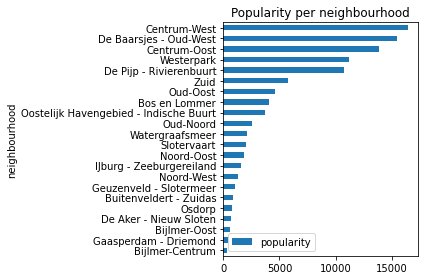

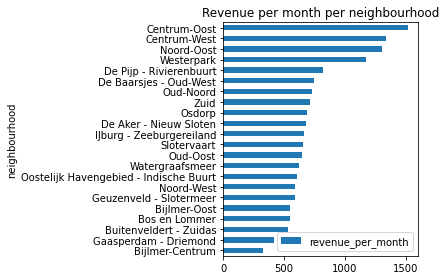

In [95]:
info_per_nbh.sort_values('price', ascending=True).plot.barh(y='price', title='Price per neighbourhood')
plt.tight_layout()
plt.savefig('nbh_price.png')
info_per_nbh.sort_values('center distance', ascending=True).plot.barh(y='center distance', title='Distance to center per neighbourhood')
plt.tight_layout()
plt.savefig('nbh_center.png')
# Adjust for neighbourhood size???
# info_per_nbh.sort_values('occupancy', ascending=True).plot.barh(y='occupancy', title='occupancy')
info_per_nbh.sort_values('popularity', ascending=True).plot.barh(y='popularity', title='Popularity per neighbourhood')
plt.tight_layout()
plt.savefig('nbh_popularity.png')
info_per_nbh.sort_values('revenue_per_month', ascending=True).plot.barh(y='revenue_per_month', title='Revenue per month per neighbourhood')
plt.tight_layout()
plt.savefig('nbh_revenue.png')


The center is expensive and so is A'dam Zuid directly south of the center with a skyline and the islands IJburg/Zeeburgereiland not too far from the center. In general the further from the center the cheaper the listing. 

(Maak map)

In [68]:
import folium
from folium.plugins import FastMarkerCluster
# # unsuccesful installation
# import geopandas as gpd
from branca.colormap import LinearColormap

In [69]:
lats = data['latitude'].tolist()
lons = data['longitude'].tolist()
locations = list(zip(lats, lons))

map1 = folium.Map(location=[52.3680, 4.9036], zoom_start=11.5)
FastMarkerCluster(data=locations).add_to(map1)
map1


In [70]:
# feq = info_per_nbh['price']

# adam = gpd.read_file("../input/neighbourhoods.geojson")
# feq = pd.DataFrame([feq])
# feq = feq.transpose()
# adam = pd.merge(adam, feq, on='neighbourhood', how='left')
# adam.rename(columns={'price': 'average_price'}, inplace=True)
# adam.average_price = adam.average_price.round(decimals=0)

# map_dict = adam.set_index('neighbourhood')['average_price'].to_dict()
# color_scale = LinearColormap(['yellow','red'], vmin = min(map_dict.values()), vmax = max(map_dict.values()))

# def get_color(feature):
#     value = map_dict.get(feature['properties']['neighbourhood'])
#     return color_scale(value)

# map3 = folium.Map(location=[52.3680, 4.9036], zoom_start=11)
# folium.GeoJson(data=adam,
#                name='Amsterdam',
#                tooltip=folium.features.GeoJsonTooltip(fields=['neighbourhood', 'average_price'],
#                                                       labels=True,
#                                                       sticky=False),
#                style_function= lambda feature: {
#                    'fillColor': get_color(feature),
#                    'color': 'black',
#                    'weight': 1,
#                    'dashArray': '5, 5',
#                    'fillOpacity':0.5
#                    },
#                highlight_function=lambda feature: {'weight':3, 'fillColor': get_color(feature), 'fillOpacity': 0.8}).add_to(map3)
# map3

# Housing type

In [71]:
data_per_rmt = data.groupby('room_type')
info_per_rmt = data_per_rmt[['room_type', 'price', 'occupancy', 'revenue_per_month']].mean()
info_per_rmt['#listings'] = data_per_rmt.size()
display(info_per_rmt)

price  occupancy  revenue_per_month  #listings
room_type                                                           
Entire home/apt  145.809652   7.232615         989.620020      11169
Private room      79.106938   8.087575         598.135256       2609
Shared room       66.521127   4.112042         256.775190         71

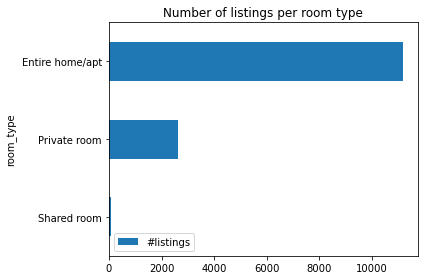

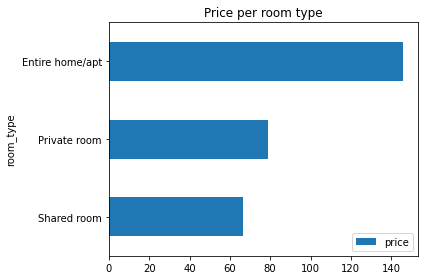

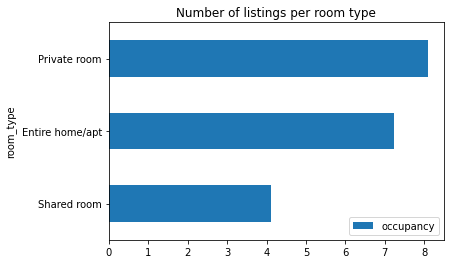

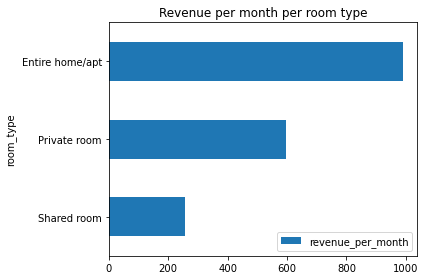

In [96]:
info_per_rmt.sort_values('#listings', ascending=True).plot.barh(y='#listings', title='Number of listings per room type')
plt.tight_layout()
plt.savefig('type_count.png')
info_per_rmt.sort_values('price', ascending=True).plot.barh(y='price', title='Price per room type')
plt.tight_layout()
plt.savefig('type_price.png')
info_per_rmt.sort_values('occupancy', ascending=True).plot.barh(y='occupancy', title='Number of listings per room type')
info_per_rmt.sort_values('revenue_per_month', ascending=True).plot.barh(y='revenue_per_month', title='Revenue per month per room type')
plt.tight_layout()
plt.savefig('type_revenue.png')

Almost all listings are entire homes, a few are private rooms. The shared rooms are very sporadic.

For an entire home you pay approximately twice as much, which is not bad if you come with enough people. A shared room is little less than a private room. 

The private rooms are the most occupied listings followed by entire homes and as might be expected shared rooms are less popular. However, this data is a very rough estimate and not very reliable and shared room data about occupancy might be inaccurate as a result of the low number of listings.

The last data about the revenue is based on this and is also rather roughly estimated, but it seems as if having two rooms to rent is already more favourable than an entire home. However a lot of appartments might have few rooms since Amsterdam is expensive and crowded, so two rooms might already come down to an entire appartment. A shared room seems less lucrative, but also you won't loose a room beacuse of it. No clear advice on what is best here.

# Rank listings for tourists

Rate distance to center and price and add up. Separately for whole appartments and rooms.

In [111]:
data_appt.quantile(0.1)

id                                1.272352e+06
host_id                           1.917313e+06
latitude                          5.234969e+01
longitude                         4.852794e+00
price                             8.400000e+01
minimum_nights                    1.000000e+00
number_of_reviews                 0.000000e+00
last_review                       7.000000e+00
reviews_per_month                 2.100000e-01
calculated_host_listings_count    1.000000e+00
availability_365                  0.000000e+00
occupancy                         1.028571e+00
revenue_per_month                 1.234286e+02
center distance                   1.092809e+00
grade                             5.345820e+00
Name: 0.1, dtype: float64

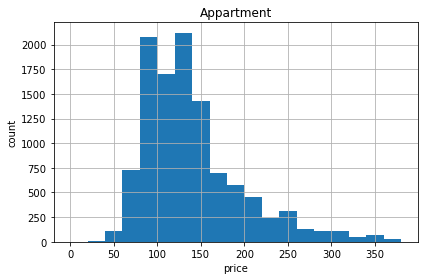

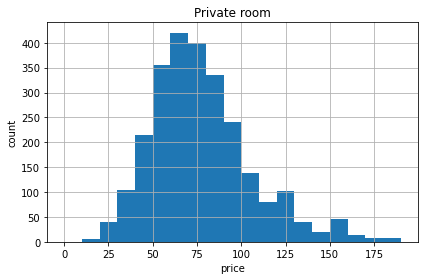

In [115]:
data_appt = data_per_rmt.get_group('Entire home/apt')
data_room = data_per_rmt.get_group('Private room')

data_appt.hist('price', bins=np.arange(0, 400, 20))
plt.xlabel('price')
plt.ylabel('count')
plt.title('Appartment')
plt.tight_layout()
plt.savefig('type_price_appt.png')
data_room.hist('price', bins=np.arange(0, 200, 10))
plt.xlabel('price')
plt.ylabel('count')
plt.title('Private room')
plt.tight_layout()
plt.savefig('type_price_room.png')

data_appt.describe()
price_appt_min = data_appt['price'].quantile(0.1)
price_appt_max = data_appt['price'].quantile(0.9)
price_room_min = data_room['price'].quantile(0.1)
price_room_max = data_room['price'].quantile(0.9)
location_min = data['center distance'].quantile(0.1)
location_max = data['center distance'].quantile(0.9)
# print(price_appt_min)
# print(price_appt_max)

# appt: 84-226
# room: 45-120

def rate(row):
    if row['room_type'] == 'Entire home/apt':
        grade_price = 10* (price_appt_max-row['price']) / (price_appt_max-price_appt_min)
        grade_price = min(max(grade_price, 0), 10)
    elif row['room_type'] == 'Private room':
        grade_price = 10* (price_room_max-row['price']) / (price_room_max-price_room_min)
        grade_price = min(max(grade_price, 0), 10)
    else:
        grade_price = float("nan")
    
    grade_location = 10* (location_max-row['center distance']) / (location_max-location_min)
    grade_location = min(max(grade_location, 0), 10)
    
    return (grade_price+grade_location)/2

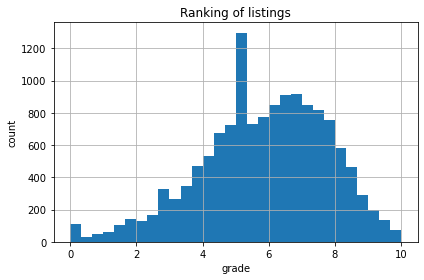

In [116]:
data['grade'] = data.apply(rate, axis=1)
data['grade'].hist(bins=30)
plt.xlabel('grade')
plt.ylabel('count')
plt.title('Ranking of listings')
plt.tight_layout()
plt.savefig('ranking.png')


Of course tourists should also check ratings from reviews and read reviews, check the host and see what they want to see in the city.

# Owners

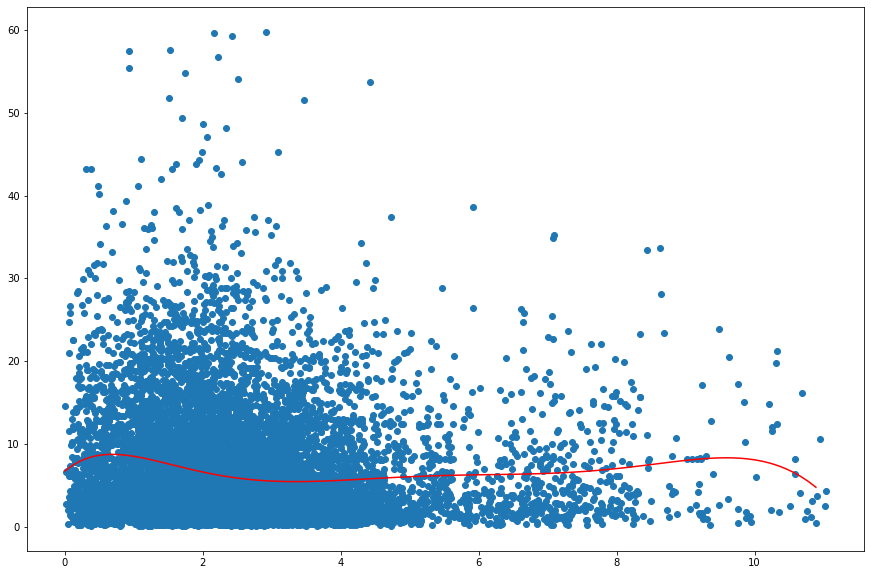

In [75]:
x=data['center distance'].to_numpy()
y=data['occupancy'].to_numpy()
x=x[y<60]
y=y[y<60]
plt.figure(figsize=(15,10))
plt.scatter(x,y)
coef = np.polyfit(x, y, deg=7)
coef = np.flip(coef) # = coef[::-1]
X = np.arange(0, 11, 0.11)
Y = np.zeros(len(X))
for power in range(len(coef)):
    Y += coef[power]*X**power
plt.plot(X, Y, 'r')

The occupancy doesn't seem to be dependent on distance from the center.

Let's look at the distance from the city center. Where do most listings ly and at which distance is the density high?

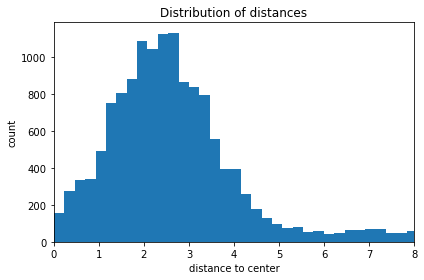

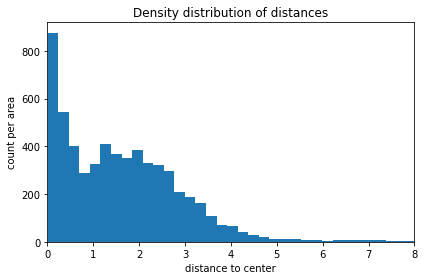

In [119]:
N = 50

plt.figure()#figsize=(15,10))
hst = plt.hist(data['center distance'], bins=N)
plt.xlim(0,8)
plt.xlabel('distance to center')
plt.ylabel('count')
plt.title('Distribution of distances')
plt.tight_layout()
plt.savefig('distance.png')

# Account for area in which listings ly
values = hst[0]
edges = hst[1]
w = edges[1]-edges[0]
x = np.array( [(edges[n]+edges[n+1])/2 for n in range(len(edges)-1)] )
new_values = values/(2*np.pi*x*w)
plt.figure()#figsize=(15,10))
plt.bar(x, new_values, width=w)
plt.xlim(0,8)
plt.xlabel('distance to center')
plt.ylabel('count per area')
plt.title('Density distribution of distances')
plt.tight_layout()
plt.savefig('distance_adj.png')

We can see a clear concentration at the city center, but not too close. This might be an indication that this is a favourable distance to be hosting, maybe also considering prices of houses against revenue.

# Rules for hosting

From "Ruimte voor Gasten, een uitwerking van de notitie toeristische verhuur van woningen (vakantieverhuur)":


"Vakantieverhuur is incidentele verhuur van de eigen woning en mag alleen onder strikte voorwaarden en als het veilig, rustig en eerlijk gebeurt.

Toeristische woningverhuur mag alleen als:

- De hoofdbewoner verhuurt en ingeschreven staat bij de GBA,

- Er aan maximaal 4 personen wordt verhuurd,

- Incidenteel, bijvoorbeeld als de hoofdbewoner op vakantie is,

- De verhuurder zich meldt bij de Dienst Belastingen Gemeente Amsterdam (DBGA) en toeristenbelasting afdraagt,

- De woning aan de brandveiligheidseisen voor woningen voldoet,

- Er geen overlast wordt veroorzaakt en buren worden geïnformeerd."



From "verhuur aan gasten, versie maart 2015":

- "toeristenbelasting: ja,

- maximaal aantal gasten: 4,

- minimaal verblijf: vanaf 1 nacht,

- maximaal verblijf: 2 maanden per jaar,

- oppervlakte t.b.v. verhuur: gehele woning,

- vergunning nodig: geen,

- bewoning: verhuurder blijft hoofdbewoner."


We can only check two. We can check whether the main resident is hosting, since you can only be main resident in one house and everyone should thus have one listing. We can check whether the maximum duration of stays is exceeded. The latter is however tricky.

Also there might be legal hotels and airbnbs or short-stay homes, so with permission from the municipality. This should be checked by the municipality.

## Listings count

We will first look at people who have a lot of listings and we might learn from these listings about how people who break the 60-day rule behave, since they are most likely these kind of people. Having listings outside of your own home seems to be illegal too.

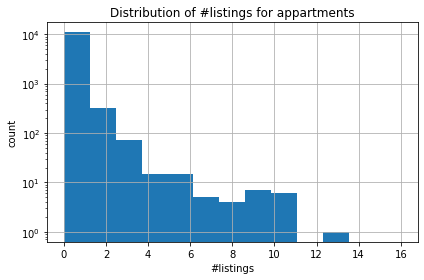

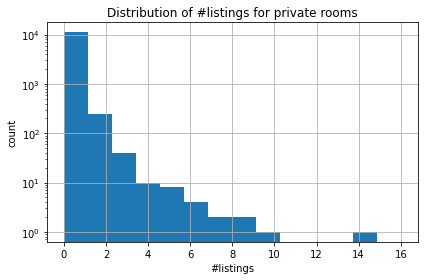

In [121]:
hosts = pd.get_dummies(data['room_type'])
hosts['id'] = data['host_id']
hosts = hosts.groupby('id').agg(sum)

hosts['Entire home/apt'].hist(bins=13, range=(0,16), log=True)
plt.xlabel('#listings')
plt.ylabel('count')
plt.title('Distribution of #listings for appartments')
plt.tight_layout()
plt.savefig('listings_appt.png')

plt.figure()
hosts['Private room'].hist(bins=14, range=(0,16), log=True)
plt.xlabel('#listings')
plt.ylabel('count')
plt.title('Distribution of #listings for private rooms')
plt.tight_layout()
plt.savefig('listings_room.png')

There are quite some people with many listings, let's take a look at these hosts.

In [78]:
Ind = 10
cat = 'Entire home/apt'
data[ data['host_id']==hosts.sort_values(cat, ascending=False).index[Ind] ]#['center distance']

id                                               name   host_id  \
1565    3374332                GORGEOUS APT+HEART OF JORDAN+CENTER  14183886   
1648   13133594  New and lovely apt. in the city center,4 coupl...  14183886   
1887    2773486                 CENTRAL COZY APARTMENT W/ TERRACE   14183886   
2204    3369911                STUNNING APARTMENT W/CANAL VIEW !!!  14183886   
3814   13793307  Centrally located,spacious, light filled apart...  14183886   
4705    1426799                TRENDY COZY APTARTMENT IN AMSTERDAM  14183886   
4712    6757805                THREE FLOORS HOUSE +CENTER+ANTIQUE.  14183886   
6413    4466667  GREAT APARTMENT IN JORDAN AREA,WESTERPARK,W/GA...  14183886   
6624   12965116  Super Cozy 45 m2 suitable for couples and family.  14183886   
7186    8618260                ULTIMATE RELAX+AMS.CENTER+BEST AREA  14183886   
9365    3101135   LUXURY IN THE CENTER+135M DUPLEX+VONDELPARK+COZY  14183886   
9400   13322309               NEW DESIGNED APT. IN AMSTERDAM ZUID.  14183886   
10289  12224966                    PEACEFUL APT,2 ROOMS, 4 PEOPLE.  14183886   
10323   9707876                  MODERN APT+CENTER+WITH 2 BIKES !!  14183886   
10339   3827439                    LUXURY DUPLEX APARTMENT 128m2    14183886   
10513   4486178                 BEST 4 COUPLES+VONDELPARK+CENTER !  14183886   
10541  13661461  HUGE TERRACE APT. IN AMSTERDAM NEXT TO VONDELP...  14183886   
10671   2497424                     STYLISH APT+NEXT2 REMBRANDPARK  14183886   
11002  10080650                APT. FOR COUPLES NEXT TO VONDELPARK  14183886   

      host_name           neighbourhood   latitude  longitude  \
1565       Luis            Centrum-West  52.375137   4.881147   
1648       Luis            Centrum-West  52.382637   4.886560   
1887       Luis            Centrum-West  52.379615   4.880455   
2204       Luis            Centrum-West  52.368348   4.883123   
3814       Luis            Centrum-Oost  52.362420   4.914821   
4705       Luis            Centrum-Oost  52.369370   4.926749   
4712       Luis            Centrum-Oost  52.372918   4.905279   
6413       Luis              Westerpark  52.383680   4.873154   
6624       Luis              Westerpark  52.379488   4.868688   
7186       Luis              Westerpark  52.392946   4.871920   
9365       Luis                    Zuid  52.356636   4.871567   
9400       Luis                    Zuid  52.345490   4.859105   
10289      Luis  De Baarsjes - Oud-West  52.370581   4.849614   
10323      Luis  De Baarsjes - Oud-West  52.368927   4.850616   
10339      Luis  De Baarsjes - Oud-West  52.369273   4.865801   
10513      Luis  De Baarsjes - Oud-West  52.359919   4.868038   
10541      Luis  De Baarsjes - Oud-West  52.360732   4.858175   
10671      Luis  De Baarsjes - Oud-West  52.367105   4.849987   
11002      Luis  De Baarsjes - Oud-West  52.361689   4.861090   

             room_type  price  minimum_nights  number_of_reviews last_review  \
1565   Entire home/apt    149               2                 25  2016-01-07   
1648   Entire home/apt     99               3                  1  2016-05-28   
1887   Entire home/apt    120               4                  1  2014-07-28   
2204   Entire home/apt    130               2                  4  2014-08-07   
3814   Entire home/apt    160               3                  0         NaN   
4705   Entire home/apt    105               3                 82  2016-04-28   
4712   Entire home/apt    168               2                  5  2015-07-28   
6413   Entire home/apt    129               3                  1  2016-05-16   
6624   Entire home/apt     54               2                  1  2016-05-24   
7186   Entire home/apt     95               2                  3  2015-11-17   
9365   Entire home/apt    111               3                 14  2016-05-07   
9400   Entire home/apt     95               2                  0         NaN   
10289  Entire home/apt     97               3                  0       

Some seem to be hotels or B&B's, also based on the locations, but not all. Based on this and on own considerations I consider that the following will be indicators for illegal behaviour:

- minimum #nights no higher than 3
- availability higher than 200


- recent activity
- high reviews per month
- high reviews total
- low price
- high number of listings, unless a few private rooms


People who want to make money don't mind the trouble of short stays too much so won't have a high minimum #nights. The availablility of at least some of the listings is very high. In general of course these people will have recent activity, and a lot of reviews.

I expect that the price will be a bit lower than the average, to make sure the listing is constantly booked. However to determine if a price is low, we should take into account the worth of the listing, which depends on the location, size, interior, facilities, etc. Therefore it is too hard to determine whether the price is a little lower than the rest.

Of course also there might be a lot of listings from the same host, but not necessarily. It makes sense to start doing checks on those people since they form the biggest problem.

### Recent activity

Determine date of snapshot.

In [79]:
from datetime import datetime
today = datetime.strptime('2016-07-04', '%Y-%m-%d')

print(today)
def str2daysago(s):
    if not isinstance(s, str):
     return s
    x = today-datetime.strptime(s, '%Y-%m-%d')
    return x.days

data['last_review'].apply(str2daysago).describe()

2016-07-04 00:00:00


count    11386.000000
mean        86.574917
std        140.403115
min          0.000000
25%         14.000000
50%         34.000000
75%         85.000000
max       1756.000000
Name: last_review, dtype: float64

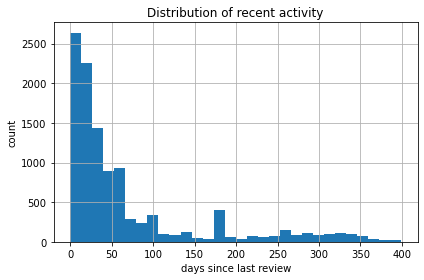

In [122]:
data['last_review'] = data['last_review'].apply(str2daysago)
data['last_review'].describe()

data[data['last_review']<400]['last_review'].hist(bins=30)
plt.xlabel('days since last review')
plt.ylabel('count')
plt.title('Distribution of recent activity')
plt.tight_layout()
plt.savefig('activity.png')

About half of the listings have had a review the past month. To select the most suspicious, we might take the most recent quantile. There is an unimportant peak corresponding to NYE.

### Availability

Houses that are available most of the time might be not just incidental use and some of these people might be breaking the rule of 60 days per year. Someone intending to exploit more than 60 days and potentially using the house or room not as a home would put the availability to a maximum and have some bookings up to 60 days reducing the availability the coming year buy a maximum of 60. This might explain the plateau between 365 and 305 and the ddecrease below this plateau. This is a suspicious area. The low availabilities are most probably people having more incidental hostings as is desirable by the muncipality. There is also an unimportant peak around half a year, because people plan this much ahead probably.

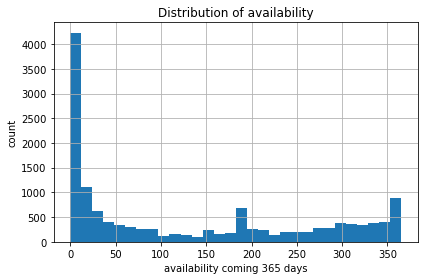

In [123]:
data['availability_365'].hist(bins=30)
plt.xlabel('availability coming 365 days')
plt.ylabel('count')
plt.title('Distribution of availability')
plt.tight_layout()
plt.savefig('availability.png')

### Review count

Listings with a lot of reviews are suspicious. Per year one would expect around 60/3.9\*0.7=10 reviews per year. This may indicate professional/business use of a property. Of course data from before regulations might be interfering. Still high number of reviews might still indicate people who used to do it too much or professionally and thus might still be doing that. More than hundred reviews raises suspicion.

(http://insideairbnb.com/amsterdam/#:~:text=A%20review%20rate%20of%2050,guests%20using%20Airbnb%20in%20Amsterdam)

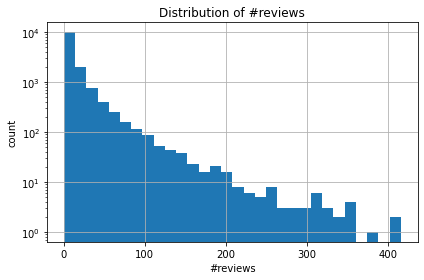

In [124]:
data['number_of_reviews'].hist(bins=30)
plt.yscale('log')
plt.xlabel('#reviews')
plt.ylabel('count')
plt.title('Distribution of #reviews')
plt.tight_layout()
plt.savefig('reviews.png')

### Review count per month

Of course the number of reviews will be high for those who break the 60 days per year rule.

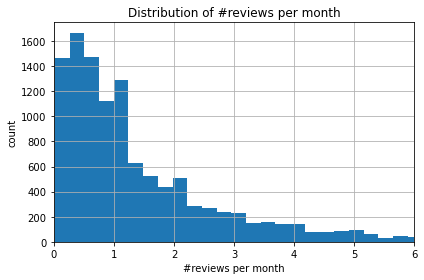

In [127]:
data['reviews_per_month'].hist(bins=50)
plt.xlim(0,6)
plt.xlabel('#reviews per month')
plt.ylabel('count')
plt.title('Distribution of #reviews per month')
plt.tight_layout()
plt.savefig('reviews_month.png')

We see that more than 4 is quite exceptional already.

### Minimum #nights

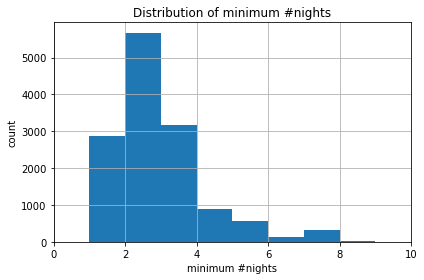

In [134]:
data[data['minimum_nights']<=30]['minimum_nights'].hist(bins=29, align='mid')
plt.xlim(0,10)
plt.xlabel('minimum #nights')
plt.ylabel('count')
plt.title('Distribution of minimum #nights')
plt.tight_layout()
plt.savefig('minimum_nights.png')

### Selection procedure

We will take hard cut-offs for:
- minimum #nights no higher than 3
- availability higher than 200.


We will take quantiles for:
- recent activity
- high reviews per month
- high reviews total.


In [85]:
top = 0.2

quant_min = data[['last_review']].quantile(top)
quant_max = data[['reviews_per_month', 'number_of_reviews']].quantile(1-top)
print(data.columns)
print(quant_min)

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365', 'occupancy',
       'revenue_per_month', 'center distance', 'grade'],
      dtype='object')
last_review    11.0
Name: 0.2, dtype: float64


In [86]:
susp = data[data['minimum_nights']<4]
susp[ susp['availability_365']>200 ]

susp = susp[ susp['last_review']<quant_min['last_review'] ]
susp = susp[ susp['reviews_per_month']>quant_max['reviews_per_month'] ]
susp = susp[ susp['number_of_reviews']>quant_max['number_of_reviews'] ]
print(len(susp))
susp.sort_values('price')

516


id                                 name   host_id     host_name  \
7294   11608012  NEW!! 1-3p AMC,ZIGGO Dome,ING,WI-FI  47501089        Mariah   
10688    288967          BandB de Baarsjes Amsterdam   1501422         Erwin   
11272   3786000     Little room close to City Centre  19279371         Annet   
514     7539417   Charming Room - 2.5km from station  39503013       Luciano   
13763    979866   feel home and free in Jayantihouse   3717123       Jayanti   
...         ...                                  ...       ...           ...   
1468    8353121  Best central location in Amsterdam!  18472746           Ian   
1299    4422039               Singel Canal Apartment  22944920         Irina   
3678    5959225   Amsterdam Rembrandtplein Apartment  25389632           Dan   
4297    9227303   Charming Penthouse w/ Roof Terrace   3014623  Nany Trivita   
3602    3902098  Cosy, Classic Sailing Ship "de Lis"  20206349          Leon   

                                neighbourhood   latitude  longitude  \
7294                          Bijlmer-Centrum  52.317961   4.954291   
10688                  De Baarsjes - Oud-West  52.361918   4.855507   
11272                  De Baarsjes - Oud-West  52.360515   4.863943   
514                                 Oud-Noord  52.399970   4.911684   
13763                  De Aker - Nieuw Sloten  52.353320   4.785443   
...                                       ...        ...        ...   
1468                             Centrum-West  52.370130   4.880669   
1299                             Centrum-West  52.376923   4.891394   
3678                             Centrum-Oost  52.366760   4.896666   
4297                             Centrum-Oost  52.368614   4.897436   
3602   Oostelijk Havengebied - Indische Buurt  52.378494   4.935806   

             room_type  price  minimum_nights  number_of_reviews  last_review  \
7294      Private room     25               1                 21          4.0   
10688     Private room     30               2                201          4.0   
11272     Private room     35               3                133         10.0   
514       Private room     37               2                 48          5.0   
13763     Private room     38               2                120          9.0   
...                ...    ...             ...                ...          ...   
1468   Entire home/apt    261               1                 32          5.0   
1299   Entire home/apt    273               3                 68          8.0   
3678   Entire home/apt    300               1                 71          4.0   
4297   Entire home/apt    321               1                 39          7.0   
3602   Entire home/apt    451               2                 58          7.0   

       reviews_per_month  calculated_host_listings_count  availability_365  \
7294                6.70                               1               104   
10688               4.01                               2               218   
11272               5.77                               3               185   
514                 4.32                               2               330   
13763               3.02                               2               286   
...                  ...                             ...               ...   
1468                3.79                               3               261   
1299                5.15                               2               232   
3678                5.73                               2               279   
4297                6.00                               1               293   
3602                2.89                               1               198   

       occupancy  revenue_per_month  center distance     grade  
7294   13.782857         344.571429         7.311600  0.000000  
10688  16.498286         494.948571         3.187244  1.743685  
11272  35.609143        1246.320000         2.760783  2.401717  
514    17.773714         657.

Hosts might be tended to do the illegal activities around the center, because there they expect toursts to book a lot. This is also where the heart problem is for the municipality, so I recommend starting there. The municipality might adjust boundaries as doing inspections.

The revenue made illegally is a fraction of the revenue foudn here, since not all hosts are guilty. We will make the guess that only 10% of listings are illegal.

In [87]:
illegal_revenue = susp['revenue_per_month'].sum()*0.1
print('Illegal revenue estimated: {} euro'.format(illegal_revenue))

Illegal revenue estimated: 85508.78605714288 euro


# Revenue

The average housing price in Amsterdam is about 518,000 euro*. We want to calculate the monthly return on investment (ROI) through Airbnb, if we would be hosting all year. If we consider houses rented out all year through, we want to take consider only listings that are suspected to be rented out about all year through, which we will do by demanding high availability (considering they might be already booked for some time) of at least 270 the coming 365 days. 

We account for some living expenses of 250 euro**. Waterschapsbelasting, afvalstoffen- en rioolheffing, g/w/l, onderhoud.

\*(https://www.parool.nl/amsterdam/gemiddelde-prijs-koopwoning-amsterdam-weer-gestegen-518-000-euro~b796a1b7/#:~:text=Gemiddelde%20prijs%20koopwoning%20Amsterdam%20weer%20gestegen%3A%20518.000%20euro,-Ondanks%20de%20pandemie)

\**(https://www.nul20.nl/huurders-amsterdam-zijn-ruim-40-procent-van-hun-inkomen-aan-woonlasten-kwijt#:~:text=Huurders%20in%20Amsterdam%20zijn%20ruim%2040%20procent%20van%20hun%20inkomen%20aan%20woonlasten%20kwijt,-04.04.19&text=Huurders%20besteden%20gemiddeld%2038%2C1,procent%20en%20in%20Amsterdam%2032.)

In [88]:
# Alleen entire home/appt!!!
revenue_per_month = susp[susp['room_type']=='Entire home/apt']['revenue_per_month'].mean()
profit_per_month = revenue_per_month-250
house_price = 5.18e5
ROI_monthly = profit_per_month/house_price

print('The average revenue per month for a house is {}.'.format(revenue_per_month))
print('An estimate for the price of for a house is {}.'.format(house_price))
print('Monthly ROI is {}%.'.format(ROI_monthly*100))

The average revenue per month for a house is 2045.847992007992.
An estimate for the price of for a house is 518000.0.
Monthly ROI is 0.3466888015459444%.


This is not very impressive.